In [13]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# === 1. CARGAR DATOS ===
nodos = pd.read_csv("../../data/networks/nodos_IPBLN.csv")
enlaces = pd.read_csv("../../data/networks/coautorias_IPBLN.csv")

# === 2. CONSTRUIR GRAFO ===
G = nx.Graph()

# Añadir nodos (opcional si edges ya los crea)
for _, row in nodos.iterrows():
    G.add_node(row["author_id"], label=row["Label"])  # puedes añadir más atributos si quieres

# Añadir aristas ponderadas
for _, row in enlaces.iterrows():
    G.add_edge(row["Source"], row["Target"], weight=row["Weight"])

In [14]:
# === 3. APLICAR LOUVAIN ===
partition = nx.community.louvain_communities(G, resolution=1, weight='weight')  # Usa edge weights
# partition = nx.community.louvain_communities(G, resolution=0.063, weight='weight') 
# Convertir el conjunto de comunidades a una lista para facilitar el acceso si es necesario
# Aunque para modularidad, la partición tal como la devuelve louvain_communities ya es adecuada
print(f"Número de nodos en el subgrafo: {G.number_of_nodes()}")
print(f"Número de aristas en el subgrafo: {G.number_of_edges()}")

# Extraer número de comunidades
num_comunidades = len(partition)
print(f"Comunidades detectadas: {num_comunidades}")

Número de nodos en el subgrafo: 724
Número de aristas en el subgrafo: 3501
Comunidades detectadas: 73


In [15]:
# === 4. MODULARIDAD ===
# La función modularity espera un grafo y una partición (iterable de conjuntos o listas de nodos)
modularity = nx.community.modularity(G, partition, weight='weight')
print(f"Modularidad de la partición: {modularity:.4f}")

Modularidad de la partición: 0.7851


In [16]:
## Guardamos la partición en un JSON
import json

# Guardar partición en archivo JSON
with open("partition_louvain.json", "w", encoding='utf-8') as f:
    json.dump([list(community) for community in partition], f)

In [17]:
## Cargamos la partición desde el JSON
with open("partition_louvain.json", "r", encoding='utf-8') as f:
    partition = [set(community) for community in json.load(f)]

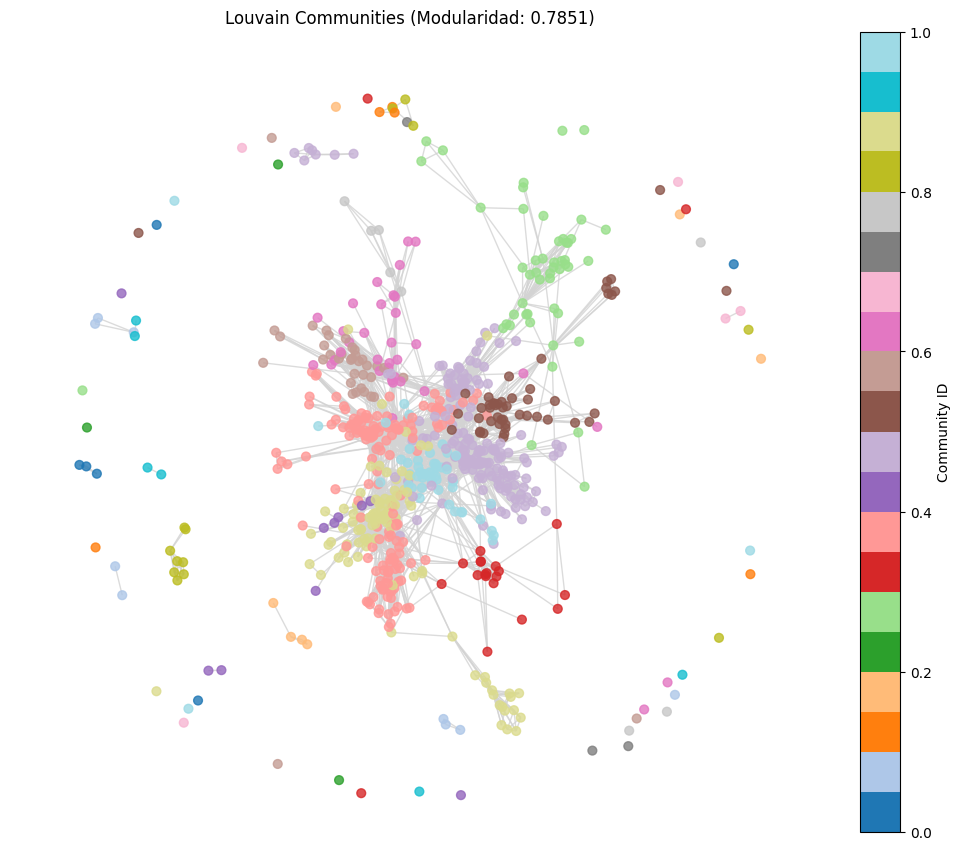

Comunidad 0: [706384]...
Comunidad 1: [747536, 747537, 747538]...
Comunidad 2: [327454]...
Comunidad 3: [688307]...
Comunidad 4: [747648, 747649, 747647]...
Comunidad 5: [439138, 439139, 439140]...
Comunidad 6: [747597, 747598]...
Comunidad 7: [737621]...
Comunidad 8: [615304]...
Comunidad 9: [395863]...
Comunidad 10: [87002, 13341, 151494]...
Comunidad 11: [699650]...
Comunidad 12: [439520, 449530, 341266, 13618]...
Comunidad 13: [408845]...
Comunidad 14: [403526]...
Comunidad 15: [403510]...
Comunidad 16: [190734]...
Comunidad 17: [786478]...
Comunidad 18: [594390]...
Comunidad 19: [402720]...
Comunidad 20: [678130]...
Comunidad 21: [451072, 451073, 430465, 315011, 436227]...
Comunidad 22: [420682]...
Comunidad 23: [141632]...
Comunidad 24: [396172]...
Comunidad 25: [129152, 164258, 13157, 129126, 342824]...
Comunidad 26: [22272, 636803, 128644, 128135, 21774]...
Comunidad 27: [21816, 128838, 129127, 128653, 194895]...
Comunidad 28: [128384, 127888, 127889, 127890, 4243]...
Comunidad

In [18]:
# === 5. VISUALIZACIÓN (corregido) ===
pos = nx.spring_layout(G, seed=42) # Usar un seed para reproducibilidad del layout

# Crear un mapeo de nodo a un índice de comunidad
node_community_map = {}
for i, comm in enumerate(partition):
    for node in comm:
        node_community_map[node] = i

# Ahora puedes usar este mapeo para los colores
colors = [node_community_map[node] for node in G.nodes()]

# Dibujar el grafo
plt.figure(figsize=(10, 8)) # Ajusta el tamaño de la figura si es necesario
nx.draw(
    G,
    pos,
    node_color=colors,
    with_labels=False, # Generalmente con muchos nodos, las etiquetas son un desorden
    node_size=40,
    cmap=plt.cm.tab20, # cmap es importante para tener suficientes colores distintivos
    edge_color='lightgray', # Hace que las aristas sean menos dominantes
    alpha=0.8 # Transparencia para ver mejor los nodos
)
plt.title(f"Louvain Communities (Modularidad: {modularity:.4f})")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab20), ax=plt.gca(), orientation='vertical', label='Community ID')
plt.show()

# Opcional: Si quieres ver las etiquetas de comunidad o algunos detalles más
# Puedes imprimir las comunidades para verificar:
for i, comm in enumerate(partition):
   print(f"Comunidad {i}: {list(comm)[:5]}...") # Muestra solo los primeros 5 nodos

In [19]:
# --- Preparar los datos para el CSV ---

# 1. Crear un mapeo de nodo a su ID de comunidad
node_to_community_id = {}
for i, community_nodes in enumerate(partition):
    for node in community_nodes:
        node_to_community_id[node] = i

# 2. Crear una lista de diccionarios para el DataFrame
data = []
for node in G.nodes():
    data.append({
        'author_id': node,
        'Community_ID': node_to_community_id.get(node, -1) # Usar .get para manejar nodos que por alguna razón no estén en una comunidad (aunque con Louvain no debería pasar)
    })

# 3. Crear el DataFrame de Pandas
df_communities = pd.DataFrame(data)

# 4. Guardar el DataFrame en un archivo CSV
output_filename = '../../Data/networks/nodes_with_communities.csv'
df_communities.to_csv(output_filename, index=False) # index=False para no guardar el índice de Pandas como una columna

print(f"\nDatos de la comunidad guardados en '{output_filename}'")
print("\nPrimeras 5 filas del DataFrame:")
print(df_communities.head())


Datos de la comunidad guardados en '../../Data/networks/nodes_with_communities.csv'

Primeras 5 filas del DataFrame:
   author_id  Community_ID
0     594285            35
1     427271            21
2     390890            63
3     706384             0
4     345431            37


In [12]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Rutas de tus archivos
json_path = "../../../data/data/IPBLN/json/gesbib_authors_ipbln_info.json"
communities_csv_path = "../../data/networks/nodes_with_communities.csv" # El CSV que generaste antes
all_nodes_csv_path = "../../data/networks/nodos_IPBLN.csv" # CSV con todos los nodos (asignados y no asignados)

# --- 2. Cargar y Preprocesar los Datos de los Autores (NLP) ---

# Cargar JSON con información de autores
with open(json_path, encoding="utf-8") as f:
    author_data_raw = json.load(f)

# El JSON es un diccionario donde las claves son los IDs de autor (como strings)
# No necesitas convertirlo, ya está en el formato deseado: id_autor -> info_autor
author_info_dict = author_data_raw

# Cargar el CSV con todos los nodos (para obtener todos los IDs y Labels)
df_all_nodes = pd.read_csv(all_nodes_csv_path)

# Cargar el CSV de comunidades (para los nodos de la componente gigante)
df_communities = pd.read_csv(communities_csv_path)

# Preparar los datos textuales de todos los autores
processed_author_texts = []
author_ids_with_text = []

# Iterar sobre todos los autores en df_all_nodes para asegurar que procesamos todos
for author_id_int in df_all_nodes['author_id']:
    # El ID en el JSON es una cadena, asegúrate de que coincida el tipo
    author_id_str = str(author_id_int)
    info = author_info_dict.get(author_id_str)

    if info:
        # Extraer y combinar los campos de texto
        # Si son diccionarios, queremos las claves (las materias/palabras clave)
        materias_jcr = " ".join(info.get('materiasJcr', {}).keys())
        materias_cs = " ".join(info.get('materiasCs', {}).keys())

        combined_text = f"{materias_jcr} {materias_cs}".lower()
        # Limpieza básica: eliminar espacios extra
        combined_text = ' '.join(combined_text.split())

        processed_author_texts.append(combined_text)
        author_ids_with_text.append(author_id_int) # Guardamos el ID como entero
    else:
        # Manejar autores para los que no se encontró información detallada
        processed_author_texts.append("") # Texto vacío
        author_ids_with_text.append(author_id_int)

# Crear un DataFrame con todos los autores y su texto combinado
df_all_authors_text = pd.DataFrame({
    'author_id': author_ids_with_text,
    'combined_text': processed_author_texts
})

# Fusionar con la información de las comunidades ya asignadas
# Asegúrate de que 'id_autor' en df_communities es numérico si el tuyo no lo es
df_all_authors_info = df_all_nodes.merge(df_all_authors_text, on='author_id', how='left')
df_all_authors_info = df_all_authors_info.merge(df_communities[['author_id', 'Community_ID']], on='author_id', how='left')

# Los nodos no asignados de la componente gigante tendrán NaN en 'Community_ID'
df_all_authors_info['Community_ID'] = df_all_authors_info['Community_ID'].fillna(-1).astype(int)

print("--- DataFrame consolidado con texto y Community_ID ---")
print(df_all_authors_info.head())
print(f"\nTotal de autores: {len(df_all_authors_info)}")
print(f"Autores con Community_ID asignada (de Louvain): {df_all_authors_info[df_all_authors_info['Community_ID'] != -1].shape[0]}")
print(f"Autores sin Community_ID asignada (a clasificar): {df_all_authors_info[df_all_authors_info['Community_ID'] == -1].shape[0]}")

--- DataFrame consolidado con texto y Community_ID ---
   author_id                      Label  \
0     594285         Palacios Mejía, F.   
1     427271                Verdejo, S.   
2     390890            Barreiro, Laura   
3     706384          de Groof, Aurélie   
4     345431  Herrera Campos, Ana Belén   

                                       combined_text  Community_ID  
0                                                               -1  
1  zoology ecology, evolution, behavior and syste...             3  
2        biochemistry & molecular biology biophysics             2  
3                                                               -1  
4  oncology genetics & heredity biotechnology & a...             0  

Total de autores: 724
Autores con Community_ID asignada (de Louvain): 635
Autores sin Community_ID asignada (a clasificar): 89


In [66]:
from collections import defaultdict

# --- 3. Mapeo de Comunidades de Louvain a Departamentos (Sección Automática/Semi-Automática) ---
json_path = "../../../data/data/IPBLN/json/gesbib_authors_ipbln_info.json"

# Cargar JSON
with open(json_path, encoding="utf-8") as f:
    author_data = json.load(f)

rows = []
# Crear estructura para almacenar datos
for author_id, data in author_data.items():
    materias = defaultdict(int)
    
    # Añadir materias JCR
    for m, v in data.get("materiasJcr", {}).items():
        materias[m.lower().strip()] += v
        
    # Añadir materias CS
    for m, v in data.get("materiasCs", {}).items():
        materias[m.lower().strip()] += v

    # Crear fila
    row = {"author_id": author_id}
    row.update(materias)
    rows.append(row)

# Crear DataFrame
df = pd.DataFrame(rows)
df = df.fillna(0)  # reemplazar NaNs con 0
# Mostrar resumen
print(f"Autores: {df.shape[0]} | Materias distintas: {df.shape[1] - 1}")
df.head()

Autores: 724 | Materias distintas: 335


,author_id,"chemistry, organic","chemistry, medicinal","chemistry, multidisciplinary",materials chemistry,molecular biology,pharmaceutical science,general medicine,clinical biochemistry,metals and alloys,...,regional & urban planning,"management, monitoring, policy and law",nature and landscape conservation,nuclear science & technology,radiation,otorhinolaryngology,"medicine, legal",mathematical physics,small animals,urban studies
0,2078,3.0,2.0,4.0,1.0,1.0,1.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2105,3.0,0.0,6.0,2.0,2.0,5.0,7.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4243,1.0,0.0,1.0,0.0,29.0,1.0,38.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4244,7.0,4.0,4.0,0.0,34.0,3.0,67.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13157,6.0,6.0,82.0,50.0,4.0,11.0,28.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
import json
import pandas as pd

# === Cargar datos ===

# Ruta al JSON con información de autores
with open("../../../data/data/IPBLN/json/gesbib_authors_ipbln_info.json", "r", encoding="utf-8") as f:
    datos_autores = json.load(f)

# Cargar CSV con las comunidades
df_comunidades = pd.read_csv("../../data/departamentos_clasificados.csv")  # columnas: author_id, Community_ID

# Lista de nombres conocidos del departamento "Biología celular e inmunología"
nombres_departamento_molecular = [
    "Berzal Herranz, Alfredo",
    "Daza Martín, Manuel",
    "Gómez Castilla, Jordi",
    "López Giménez, Juan Francisco",
    "López López, Manuel Carlos",
    "Navarro Carretero, Miguel Ángel",
    "Sánchez Luque, Francisco José",
    "Suñé Negre, Carles María",
    "Thomas Carazo, María del Carmen"
]

nombres_departamento_inmunologia = [
    "Acosta Herrera, Marialbert",
    "Alcina Madueño, Antonio",
    "Delgado Mora, Mario",
    "González Rey, Elena",
    "Hernández López de Munain, María Cristina",
    "Macías Sánchez, Elena",
    "Márquez Ortiz, Ana María",
    "Martín Ibáñez, Javier",
    "Matesanz del Barrio, Fuencisla",
    "Oliver Pozo, Francisco Javier",
    "Ortíz Fernández, Lourdes",
    "Sancho López, Jaime",
    "Zubiaur Marcos, Mercedes"
]

nombres_departamento_farmacologia = [
    "Castanys Cuello, Santiago",
    "Estévez García, Antonio Manuel",
    "Gómez Díaz, Elena",
    "González Pacanowska, Dolores Petra",
    "Morales Sánchez, Juan Carlos",
    "Pérez-Victoria Moreno de Barreda, José María",
    "Ruiz Pérez, Luis Miguel",
    "Sánchez Navarro, Macarena",
    "Vidal Romero, Antonio Esteban"
]

# === Buscar coincidencias en firmas ===

resultados = []

for author_id_str, datos in datos_autores.items():
    firmas = [f.lower().strip() for f in datos.get("firmas", [])]
    for nombre in nombres_departamento_inmunologia:
        if nombre.lower().strip() in firmas:
            id_autor = datos.get("idAutor")
            materias_jcr = datos.get("materiasJcr", {})
            materias_cs = datos.get("materiasCs", {})
            materias = {**materias_jcr, **materias_cs}
            comunidad = df_comunidades[df_comunidades["author_id"] == id_autor]["departamento"].values
            comunidad_id = comunidad[0] if len(comunidad) > 0 else None
            resultados.append({
                "nombre": nombre,
                "id_autor": id_autor,
                "comunidad": comunidad_id,
                "materias": materias
            })
            break  # Si lo encuentra una vez, no revisa más firmas

# === Mostrar resultados ===

for r in resultados:
    print(f"✅ {r['nombre']} (ID: {r['id_autor']}) → Comunidad {r['comunidad']}")
    print("  Materias:", ", ".join(f"{k} ({v})" for k, v in r['materias'].items()))
    print()


✅ Márquez Ortiz, Ana María (ID: 21761) → Comunidad Biología celular e inmunología
  Materias: Allergy (1), Neurosciences (1), Microbiology (1), Hematology (1), Rheumatology (33), Oncology (1), Peripheral Vascular Disease (1), Genetics & Heredity (11), Biotechnology & Applied Microbiology (1), Cell Biology (2), Gastroenterology & Hepatology (4), Cardiac & Cardiovascular Systems (1), Biochemistry & Molecular Biology (7), Pathology (5), Immunology (40), Clinical Neurology (1), Medicine, General & Internal (2), Pharmacology & Pharmacy (3), Multidisciplinary Sciences (8), Ophthalmology (2), Chemistry, Multidisciplinary (1), Genetics (clinical) (8), Molecular Biology (8), Pharmaceutical Science (1), Sensory Systems (1), General Medicine (26), Computer Science Applications (1), Microbiology (medical) (1), Hepatology (2), Gastroenterology (4), Genetics (15), Physiology (1), Catalysis (1), Inorganic Chemistry (1), Multidisciplinary (5), Cellular and Molecular Neuroscience (1), Organic Chemistry

In [16]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios (solo la primera vez)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Stopwords estándar + personalizadas
stop_words = set(stopwords.words('english')).union({
    "general", "miscellaneous", "misc", "applied", "special", "multidisciplinary",
    "science", "sciences", "studies", "engineering", "technology", "systems",
    "methods", "interdisciplinary", "other", "clinical", "medical"
})

# Lematizador
lemmatizer = WordNetLemmatizer()

def clean_subject_nltk(subject):
    subject = subject.lower()
    subject = re.sub(r"[^\w\s]", " ", subject)
    tokens = nltk.word_tokenize(subject)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
from collections import defaultdict
import pandas as pd

# Copia original
df_original = df.copy()
columnas_materias = [col for col in df.columns if col != 'author_id']

# Paso 1: crear mapeo columna original → nombre limpio
col_mapping = {
    original: clean_subject_nltk(original)
    for original in columnas_materias
}

# Paso 2: agrupar columnas que se limpian al mismo nombre
grupo_materias = defaultdict(list)
for original, cleaned in col_mapping.items():
    grupo_materias[cleaned].append(original)

# Paso 3: construir columnas fusionadas en un diccionario
fusionadas = {}

for nombre_limpio, columnas in grupo_materias.items():
    fusionadas[nombre_limpio] = (
        df[columnas]
        .apply(pd.to_numeric, errors='coerce')
        .sum(axis=1, skipna=True)
        .fillna(0)
    )

# Paso 4: construir DataFrame final de una sola vez
df_fusionado = pd.concat(
    [df['author_id']] + [fusionadas[col] for col in sorted(fusionadas)],
    axis=1
)

df_fusionado.columns = ['author_id'] + sorted(fusionadas)

print(f"✅ Columnas antes: {len(columnas_materias)} | Después de fusionar: {df_fusionado.shape[1] - 1}")

✅ Columnas antes: 335 | Después de fusionar: 280


Queremos asignar los autores de cada comunidad a un departamento.

In [26]:
etiquetas_departamentos = {
    0: "Biología celular e inmunología",
    1: "Biología molecular",
    2: "Bioquímica y farmacología molecular"
}

# Cargar CSV con los autores y su comunidad asignada (si la tienen)
comunidades_df = pd.read_csv("../../data/networks/nodes_with_communities.csv")
comunidad_por_autor = dict(zip(comunidades_df['author_id'].astype(str), comunidades_df['Community_ID']))

# author_data es un diccionario preexistente con la estructura:
# { author_id: { "materiasJcr": {...}, "materiasCs": {...} } }

# === AGRUPAR MATERIAS POR AUTOR ===

materias_por_autor = {}
for author_id, data in author_data.items():
    materias = defaultdict(int)
    for m, v in data.get("materiasJcr", {}).items():
        materias[m.lower().strip()] += v
    for m, v in data.get("materiasCs", {}).items():
        materias[m.lower().strip()] += v
    materias_por_autor[author_id] = materias

# === AGRUPAR MATERIAS POR COMUNIDAD ===

materias_por_comunidad = defaultdict(lambda: defaultdict(int))

for autor_id, materias in materias_por_autor.items():
    comunidad = comunidad_por_autor.get(str(autor_id))
    if comunidad is None:
        continue  # ignorar autores sin comunidad
    for materia, peso in materias.items():
        materias_por_comunidad[comunidad][materia] += peso

# === MOSTRAR RESULTADOS (puedes exportar esto a JSON, CSV o imprimirlo) ===

for comunidad, materias in materias_por_comunidad.items():
    print(f"\n🧠 Comunidad {comunidad} ({len(materias)} materias):")
    materias_ordenadas = sorted(materias.items(), key=lambda x: x[1], reverse=True)
    for materia, peso in materias_ordenadas[:20]:  # top 20 materias por comunidad
        print(f"  {materia}: {peso}")


🧠 Comunidad 1 (226 materias):
  biochemistry & molecular biology: 1103
  general medicine: 1044
  molecular biology: 1012
  cell biology: 990
  biochemistry: 755
  immunology: 551
  pharmacology: 475
  drug discovery: 453
  molecular medicine: 447
  microbiology: 447
  chemistry, medicinal: 413
  pharmacology & pharmacy: 406
  infectious diseases: 377
  parasitology: 377
  organic chemistry: 371
  genetics: 307
  oncology: 269
  cellular and molecular neuroscience: 258
  biophysics: 247
  chemistry, multidisciplinary: 245

🧠 Comunidad 2 (288 materias):
  immunology: 2856
  general medicine: 2131
  rheumatology: 2034
  immunology and allergy: 1436
  biochemistry & molecular biology: 1033
  cell biology: 1016
  molecular biology: 970
  genetics: 947
  biochemistry: 691
  general biochemistry, genetics and molecular biology: 596
  genetics & heredity: 579
  parasitology: 510
  infectious diseases: 481
  microbiology: 376
  genetics (clinical): 375
  multidisciplinary sciences: 356
  mole

Aplicamos NLP para asignar los resultados. Una comunidad representará un departamento distinto

In [33]:
etiquetas_departamentos = {
    "Biología celular e inmunología": (
        "The department focuses on immune system mechanisms, cell signaling, T cells, B cells, immunopathology and "
        "cellular responses to infection. Topics include immunology, cell biology, inflammation and autoimmunity."
    ),
    "Biología molecular": (
        "This area studies the molecular mechanisms of gene expression, replication, transcription, RNA regulation, "
        "and protein synthesis. It covers genetics, molecular biology, DNA/RNA, and related cellular pathways."
    ),
    "Bioquímica y farmacología molecular": (
        "Dedicated to studying biochemical pathways, drug metabolism, enzyme kinetics, pharmaceutical chemistry, "
        "and mechanisms of drug action. Includes pharmacology, biochemistry, and drug discovery."
    )
}

def comunidad_to_text(materias_dict, top_n=10):
    """
    Convierte las materias y sus pesos en un texto plano repetido proporcionalmente.
    """
    sorted_items = sorted(materias_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    text = []
    for m, count in sorted_items:
        text.extend([m] * int(count))  # repite la materia según su peso
    return ' '.join(text)

Calcular similitud usando embeddings (con sentence-transformers)

In [34]:
from sentence_transformers import SentenceTransformer, util

# Cargar modelo de embedding (rápido y efectivo)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convertir departamentos a embeddings
dept_names = list(etiquetas_departamentos.keys())
dept_texts = list(etiquetas_departamentos.values())
dept_embeddings = model.encode(dept_texts, convert_to_tensor=True)

# Convertir comunidades a textos y embeddings
comunidad_embeddings = []
for id_comunidad in sorted(materias_por_comunidad.keys()):
    texto_comunidad = comunidad_to_text(materias_por_comunidad[id_comunidad])
    emb = model.encode(texto_comunidad, convert_to_tensor=True)
    comunidad_embeddings.append((id_comunidad, emb))


Comparar cada comunidad con los departamentos

In [ ]:
for id_comunidad, emb_com in comunidad_embeddings:
    similitudes = util.cos_sim(emb_com, dept_embeddings)[0]
    mejor_idx = similitudes.argmax()
    print(f"🧠 Comunidad {id_comunidad} asignada a ➜ {dept_names[mejor_idx]} (similitud: {similitudes[mejor_idx]:.3f})")
    for i, score in enumerate(similitudes):
        print(f"   - {dept_names[i]}: {score:.3f}")

🧠 Comunidad 0 asignada a ➜ Biología celular e inmunología (similitud: 0.206)
   - Biología celular e inmunología: 0.206
   - Biología molecular: 0.108
   - Bioquímica y farmacología molecular: 0.069
🧠 Comunidad 1 asignada a ➜ Bioquímica y farmacología molecular (similitud: 0.324)
   - Biología celular e inmunología: 0.155
   - Biología molecular: 0.256
   - Bioquímica y farmacología molecular: 0.324
🧠 Comunidad 2 asignada a ➜ Biología celular e inmunología (similitud: 0.380)
   - Biología celular e inmunología: 0.380
   - Biología molecular: 0.117
   - Bioquímica y farmacología molecular: 0.153


In [ ]:
import json
import pandas as pd

# === Cargar datos ===

# Ruta al JSON con información de autores
with open("../../../data/data/IPBLN/json/gesbib_authors_ipbln_info.json", "r", encoding="utf-8") as f:
    datos_autores = json.load(f)

# Cargar CSV con las comunidades
df_comunidades = pd.read_csv("../../data/networks/nodes_with_communities.csv")  # columnas: author_id, Community_ID

# Lista de nombres conocidos del departamento "Biología celular e inmunología"
nombres_departamento_molecular = [
    "Berzal Herranz, Alfredo",
    "Daza Martín, Manuel",
    "Gómez Castilla, Jordi",
    "López Giménez, Juan Francisco",
    "López López, Manuel Carlos",
    "Navarro Carretero, Miguel Ángel",
    "Sánchez Luque, Francisco José",
    "Suñé Negre, Carles María",
    "Thomas Carazo, María del Carmen"
]

nombres_departamento_inmunologia = [
    "Acosta Herrera, Marialbert",
    "Alcina Madueño, Antonio",
    "Delgado Mora, Mario",
    "González Rey, Elena",
    "Hernández López de Munain, María Cristina",
    "Macías Sánchez, Elena",
    "Márquez Ortiz, Ana María",
    "Martín Ibáñez, Javier",
    "Matesanz del Barrio, Fuencisla",
    "Oliver Pozo, Francisco Javier",
    "Ortíz Fernández, Lourdes",
    "Sancho López, Jaime",
    "Zubiaur Marcos, Mercedes"
]

nombres_departamento_farmacologia = [
    "Castanys Cuello, Santiago",
    "Estévez García, Antonio Manuel",
    "Gómez Díaz, Elena",
    "González Pacanowska, Dolores Petra",
    "Morales Sánchez, Juan Carlos",
    "Pérez-Victoria Moreno de Barreda, José María",
    "Ruiz Pérez, Luis Miguel",
    "Sánchez Navarro, Macarena",
    "Vidal Romero, Antonio Esteban"
]

# === Buscar coincidencias en firmas ===

resultados = []

for author_id_str, datos in datos_autores.items():
    firmas = [f.lower().strip() for f in datos.get("firmas", [])]
    for nombre in nombres_departamento_molecular + nombres_departamento_inmunologia + nombres_departamento_farmacologia:
        if nombre.lower().strip() in firmas:
            id_autor = datos.get("idAutor")
            materias_jcr = datos.get("materiasJcr", {})
            materias_cs = datos.get("materiasCs", {})
            materias = {**materias_jcr, **materias_cs}
            comunidad = df_comunidades[df_comunidades["author_id"] == id_autor]["Community_ID"].values
            comunidad_id = comunidad[0] if len(comunidad) > 0 else None
            resultados.append({
                "nombre": nombre,
                "id_autor": id_autor,
                "comunidad": comunidad_id,
                "materias": materias
            })
            break  # Si lo encuentra una vez, no revisa más firmas

# === Mostrar resultados ===

for r in resultados:
    print(f"✅ {r['nombre']} (ID: {r['id_autor']}) → Comunidad {r['comunidad']}")
    print("  Materias:", ", ".join(f"{k} ({v})" for k, v in r['materias'].items()))
    print()


✅ Márquez Ortiz, Ana María (ID: 21761) → Comunidad 2
  Materias: Allergy (1), Neurosciences (1), Microbiology (1), Hematology (1), Rheumatology (33), Oncology (1), Peripheral Vascular Disease (1), Genetics & Heredity (11), Biotechnology & Applied Microbiology (1), Cell Biology (2), Gastroenterology & Hepatology (4), Cardiac & Cardiovascular Systems (1), Biochemistry & Molecular Biology (7), Pathology (5), Immunology (40), Clinical Neurology (1), Medicine, General & Internal (2), Pharmacology & Pharmacy (3), Multidisciplinary Sciences (8), Ophthalmology (2), Chemistry, Multidisciplinary (1), Genetics (clinical) (8), Molecular Biology (8), Pharmaceutical Science (1), Sensory Systems (1), General Medicine (26), Computer Science Applications (1), Microbiology (medical) (1), Hepatology (2), Gastroenterology (4), Genetics (15), Physiology (1), Catalysis (1), Inorganic Chemistry (1), Multidisciplinary (5), Cellular and Molecular Neuroscience (1), Organic Chemistry (1), Neurology (clinical) (1